In [1]:
#meta How to ggplot in Py
# 5/19/2019
# refer to https://medium.com/@crscardellino/python-with-ggplot-9ed888af93ca

# Python with ggplot2
Copied from crscardellino/python-with-ggplot

## Importing the libraries

### Python Imports

In [2]:
import pandas as pd
import rpy2

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

### R Imports

In [3]:
%%R

# load the ggplot2 library
library(ggplot2)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



## Loading a dataset

In [24]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
#myfix - missing values in categorical columns
print (titanic.dtypes)
titanic['Cabin'] = titanic['Cabin'].fillna('None').astype('category')
titanic['Embarked'] = titanic['Embarked'].fillna('None').astype('category')
print (titanic.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex              object
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin          category
Embarked       category
dtype: object


### Using the dataset in R and getting the results back

In [26]:
%%R -i titanic -o titanic_mean_fare

titanic_mean_fare <- mean(titanic$Fare)

In [27]:
print("Average fare for Titanic's passengers: %.2f vs %.2f" % (titanic_mean_fare[0], titanic.Fare.mean()))

Average fare for Titanic's passengers: 32.20 vs 32.20


## Using ggplot2

### Scatter Plot (or xy plot)

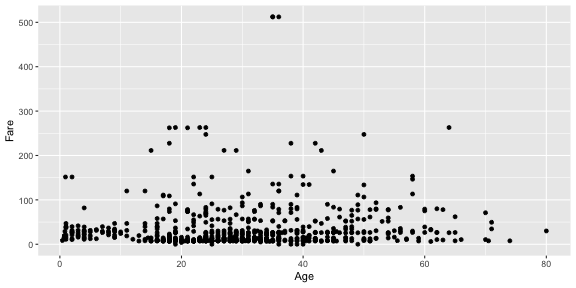

In [28]:
%%R -i titanic -w 8 -h 4 -u in

ggplot(titanic, aes(x=Age, y=Fare)) + geom_point()

### Bar Plot

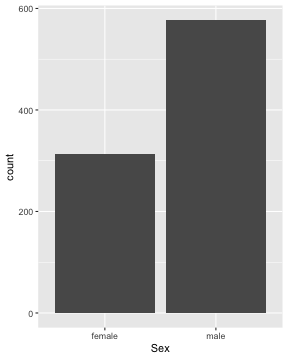

In [29]:
%%R -i titanic -w 4 -h 5 -u in

ggplot(titanic, aes(x=Sex)) + geom_bar()

### Population distribution

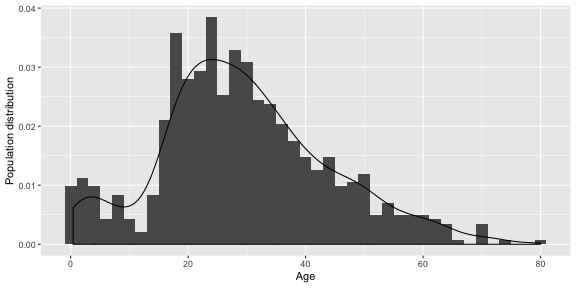

In [30]:
%%R -i titanic -w 8 -h 4 -u in

ggplot(titanic, aes(x=Age)) + geom_histogram(binwidth=2, aes(y = ..density..)) +
 geom_density() + labs(x='Age', y='Population distribution')

### Adding aesthetics

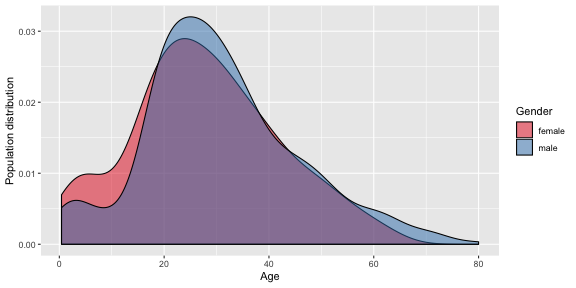

In [31]:
%%R -i titanic -w 8 -h 4 -u in

ggplot(titanic, aes(x=Age, fill=Sex)) + geom_density(alpha=0.5) +
 labs(x='Age', y='Population distribution') + 
 scale_fill_brewer(palette='Set1', name='Gender')

### Adding variables

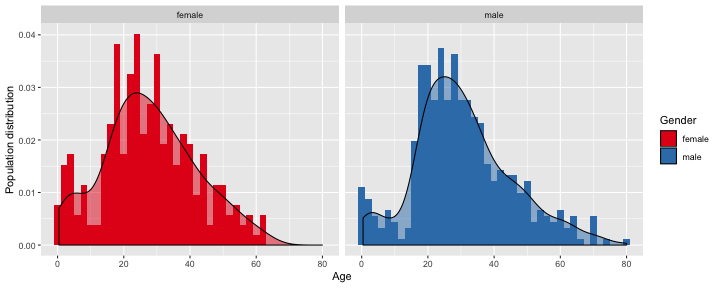

In [32]:
%%R -i titanic -w 10 -h 4 -u in

ggplot(titanic, aes(x=Age, fill=Sex)) + 
 geom_histogram(binwidth=2, aes(y = ..density..)) +
 geom_density(alpha=0.5) + labs(x='Age', y='Population distribution')+ 
 facet_wrap(~Sex) + scale_fill_brewer(palette='Set1', name='Gender')

## Combining the power of Python with the graphs of ggplot

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import learning_curve, train_test_split
from scipy.stats import mode

### Preparing the data

In [34]:
titanic = pd.read_csv('./data/titanic.csv')

# Remove useless columns
titanic = titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Fill age with median
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())

# Fill embarked port with with the most common value
mode_embarked = mode(titanic['Embarked'].fillna(''))[0][0]
titanic['Embarked'] = titanic['Embarked'].fillna(mode_embarked)

# Gender is a binary value
titanic['Sex'] = titanic['Sex'].map({'female': 0, 'male': 1}).astype(int) # Map sex with 

# Binarize the "Embarked" attribute and remove the original attribute
titanic = pd.concat([titanic, pd.get_dummies(titanic['Embarked'], prefix='Embarked')], axis=1)
titanic = titanic.drop(['Embarked'], axis=1)

/Users/Amigo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


### Plotting the learning curve

In [35]:
learning_curve_results = []

for model in (LinearSVC, LogisticRegression):
    train_sizes, train_scores, validation_scores = \
        learning_curve(model(), titanic.iloc[:,1:], titanic.iloc[:,1], cv=10)
    
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    validation_scores_mean = validation_scores.mean(axis=1)
    validation_scores_std = validation_scores.std(axis=1)
    
    for iteration in range(train_sizes.shape[0]):
        learning_curve_results.append({
            'classifier': model.__name__,
            'data_size': train_sizes[iteration],
            'data_split': 'Training',
            'score_mean': train_scores_mean[iteration],
            'score_std': train_scores_std[iteration]
        })
        
        learning_curve_results.append({
            'classifier': model.__name__,
            'data_size': train_sizes[iteration],
            'data_split': 'Validation',
            'score_mean': validation_scores_mean[iteration],
            'score_std': validation_scores_std[iteration]
        })
    
learning_curve_results = pd.DataFrame(learning_curve_results)

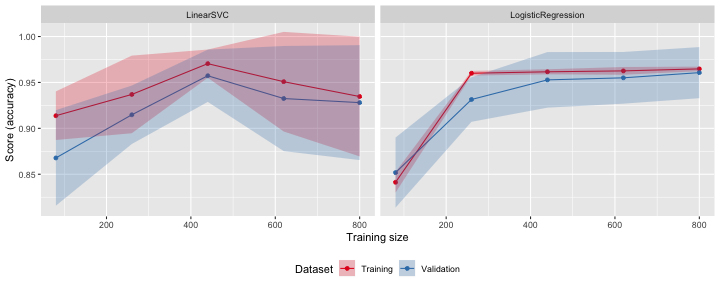

In [36]:
%%R -i learning_curve_results -w 10 -h 4 -u in

learning_curve_results$classifier <- factor(learning_curve_results$classifier,
                                            levels=c('LinearSVC', 'LogisticRegression'))

ggplot(learning_curve_results, aes(x=data_size)) +
    geom_line(aes(y=score_mean, color=data_split)) +
    geom_point(aes(y=score_mean, color=data_split)) +
    geom_ribbon(aes(ymin=score_mean-score_std,
                    ymax=score_mean+score_std,
                    fill=data_split), alpha=0.25) +
    facet_wrap(~classifier, nrow=1) +
    theme(legend.position='bottom') +
    labs(x="Training size", y="Score (accuracy)") +
    scale_color_brewer(palette='Set1', name="Dataset") +
    scale_fill_brewer(palette='Set1', name="Dataset")